In [31]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings
import shutil
import json

### Dimensionality checks

In [ ]:
df = np.load('P12data/split_1/train_physionet2012_1.npy', allow_pickle = True)

In [ ]:
# Define the base path
base_path = os.getcwd()

# Initialize a dictionary to store concatenated arrays
data_dict = {}

# Loop through split_1 to split_5
for i in range(1, 6):
    folder_name = f"P12data/split_{i}"
    folder_path = os.path.join(base_path, folder_name)
    
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist. Skipping...")
        continue

    # List all .npy files in the folder
    npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    
    # Initialize a list to store arrays
    arrays = []
    
    for npy_file in npy_files:
        file_path = os.path.join(folder_path, npy_file)
        try:
            # Load the .npy file
            array = np.load(file_path, allow_pickle=True)
            arrays.append(array)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    # Concatenate all arrays from the folder
    if arrays:
        concatenated_array = np.concatenate(arrays, axis=0)
        data_dict[folder_name] = concatenated_array
        print(f"Concatenated {len(arrays)} files in {folder_name}")
    else:
        print(f"No .npy files found in {folder_name}")

# Print a summary
print(f"Data dictionary keys: {list(data_dict.keys())}")

In [ ]:
keys = df[0].keys()

for key in keys:
    print(f'{key}: {df[0][key].shape}')

In [ ]:
maximum_ts_values_length = 0
for i in range(len(df)):
    temp_len = df[i]['ts_values'].shape[0]
    if temp_len > maximum_ts_values_length:
        maximum_ts_values_length = temp_len

print(f"Maximum ts_values length: {maximum_ts_values_length}")

In [ ]:
def get_prime_factors(n):
    """Returns the prime factors of a given number."""
    prime_factors = []
    # Divide by 2 until n is odd
    while n % 2 == 0:
        prime_factors.append(2)
        n //= 2

    # Check for odd factors from 3 onwards
    factor = 3
    while factor * factor <= n:
        while n % factor == 0:
            prime_factors.append(factor)
            n //= factor
        factor += 2

    # If n is still greater than 2, it is prime
    if n > 2:
        prime_factors.append(n)

    return prime_factors

# Example usage
number = 56
print(f"Prime factors of {number}: {get_prime_factors(number)}")

In [ ]:
for i in range(len(df)):
    if df[i]['ts_values'].shape[0]==207:
        print(i)

### EDA for full dataset

In [ ]:
df = np.concatenate([data_dict[i] for i in data_dict.keys()], axis=0)

#### Column Sparsities

In [ ]:
feature_names = {
    0: "Alb (g/dL)",
    1: "ALP (IU/L)",
    2: "ALT (IU/L)",
    3: "AST (IU/L)",
    4: "Bilirubin (mg/dL)",
    5: "BUN (mg/dL)",
    6: "Cholesterol (mg/dL)",
    7: "Creatinine (mg/dL)",
    8: "DiasABP (mmHg)",
    9: "FiO2 (0-1)",
    10: "GCS (3-15)",
    11: "Glucose (mg/dL)",
    12: "HCO3 (mmol/L)",
    13: "HCT (%)",
    14: "HR (bpm)",
    15: "K (mEq/L)",
    16: "Lactate (mmol/L)",
    17: "Mg (mmol/L)",
    18: "MAP (mmHg)",
    19: "MechVent (0-1)",
    20: "Na (mEq/L)",
    21: "NIDiasABP (mmHg)",
    22: "NIMAP (mmHg)",
    23: "NISysABP (mmHg)",
    24: "PaCO2 (mmHg)",
    25: "PaO2 (mmHg)",
    26: "pH (0-14)",
    27: "Platelets (cells/nL)",
    28: "RespRate (bpm)",
    29: "SaO2 (%)",
    30: "SysABP (mmHg)",
    31: "Temp (°C)",
    32: "TropI (μg/L)",
    33: "TropT (μg/L)",
    34: "Urine (mL)",
    35: "WBC (cells/nL)",
    36: "Weight (kg)"
}


In [ ]:
# Iterate over each column in the time series data (assumed to be shape 37 in the example)
column_sparsities = []

for i in range(37):
    sparsity_per_column = []
    for j in range(df.shape[0]):
        # Calculate sparsity for column `i` in each row
        sparsity = sum(df[j]['ts_values'][:, i] == 0) / len(df[j]['ts_values'][:, i])
        sparsity_per_column.append(sparsity)
    # Calculate the average sparsity for column `i` across all rows
    column_sparsities.append(np.mean(sparsity_per_column))

# Convert results into a pandas DataFrame for a detailed report
sparsity_report = pd.DataFrame({
    'Column Index': range(37),
    'Average Sparsity': column_sparsities
})

# Print the report
sparsity_report['Variables'] = sparsity_report['Column Index'].map(feature_names)
print(sparsity_report)

In [ ]:
# Calculate the overall average sparsity across all columns
overall_sparsity = np.mean(column_sparsities)
print(f"Overall Average Sparsity: {overall_sparsity:.2%}")

In [ ]:
# Print sorted values in the report based on their sparsity
print(sparsity_report.sort_values('Average Sparsity', ascending=False))

### Visualisations

#### Time series plot for a single patient

In [ ]:
warnings.filterwarnings('ignore')

NUMBER_OF_SELECTED_VARIABLES_SHOWN = 10

# Set a Seaborn theme and context for a clean, modern style
sns.set_theme(style="whitegrid", context="talk", palette="viridis")

random_index = random.randint(0, df.shape[0] - 1)
# Extract the data
ts_values = df[random_index]['ts_values']
ts_times = df[random_index]['ts_times']

# Create a DataFrame for plotting
selected_columns = random.sample(range(0, 37), NUMBER_OF_SELECTED_VARIABLES_SHOWN)

# Map selected indices to their feature names
selected_feature_names = [feature_names[col] for col in selected_columns]

# Create a DataFrame for plotting with descriptive column names
plot_data = pd.DataFrame(ts_values[:, selected_columns],
                         columns=selected_feature_names)
plot_data['Time'] = ts_times

# Melt the DataFrame to long format for seaborn
plot_data_melted = plot_data.melt(id_vars='Time',
                                  var_name='Variable',
                                  value_name='Value')
plot_data_melted = plot_data_melted.replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
plot_data_melted = plot_data_melted.fillna(0)  
# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=plot_data_melted, x='Time', y='Value', hue='Variable', linewidth=2)

# Add a descriptive title and label axes with larger fonts
plt.title(f'Time Series Plot for patient {random_index}', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Time (0-48 hours)', fontsize=14)
plt.ylabel('Measurement value', fontsize=14)

# Move the legend below the plot
plt.legend(
    title='Variable', 
    bbox_to_anchor=(0.5, -0.1), 
    loc='lower right', 
    borderaxespad=0, 
    fontsize=8, 
    title_fontsize=10, 
    ncol=2  # Optional: adjust the number of columns in the legend
)

# Remove unnecessary top and right spines
sns.despine()

# Adjust layout so that everything fits nicely
plt.tight_layout()

plt.show()

#### Different sensor plots for a single patient

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

# Constants
NUMBER_OF_VARIABLES = 37
VARIABLES_PER_PLOT = 4
TOTAL_PLOTS = 9

# Randomly select some data (for demonstration purposes)
random_index = random.randint(0, df.shape[0] - 1)
ts_values = df[random_index]['ts_values']
ts_times = df[random_index]['ts_times']

# Generate selected variables and divide into chunks for 9 plots
selected_columns = list(range(NUMBER_OF_VARIABLES))  # Using all variables

# Shuffle the variables to ensure randomness
random.shuffle(selected_columns)

# Split the shuffled list into 9 batches
variable_chunks = np.array_split(selected_columns, 9)

# Convert numpy arrays back to lists (optional, depending on your use case)
variable_chunks = [list(chunk) for chunk in variable_chunks]

# Create a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through the grid and plot
for idx, ax in enumerate(axes):


    if idx >= len(variable_chunks):
        ax.axis("off")  # Turn off extra plots
        continue

    # Select variables for this plot
    chunk = variable_chunks[idx]
    selected_feature_names = [feature_names[col] for col in chunk]

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame(ts_values[:, chunk],
                             columns=selected_feature_names)
    plot_data['Time (0-48 hours)'] = ts_times

    # Melt the DataFrame to long format for seaborn
    plot_data_melted = plot_data.melt(
        id_vars='Time (0-48 hours)',
        # value_vars=chunk,
        var_name='Variable',
        value_name='Measurement value'
    )

    # Set different color palette for each plot
    # Define a vivid custom palette with HEX or RGB colors
    custom_palette = [
    "#8229DE",  # Light Teal Blue
    "#A51FF0",  # Lighter Pink
    "#D242FF",  # Light Green
    "#72ECF6",  # Light Orange
    "#20D4F6",  # Light Purple
    "#3856E7",  # Lighter Turquoise
    # "#FFE7A2",  # Soft Yellow-Orange
    "#FAD4CF",  # Peachy Pink
    # "#B1C4D8",  # Muted Light Navy
    "#E8DFF0"   # Soft Lavender
]

# # Set the Seaborn palette
    palette = sns.color_palette(custom_palette)
    
    # Create the line plot for the current chunk
    sns.lineplot(
        data=plot_data_melted, 
        x='Time (0-48 hours)', 
        y='Measurement value', 
        # hue='Variable', 
        ax=ax, 
        linewidth=2,
        hue="Variable", palette=palette
    )

    # Move the legend to the upper center with a semi-transparent background
    legend = ax.legend(
        title='Variables',
        loc='upper center',
        bbox_to_anchor=(0.5, 0.95),
        fontsize=8,
        title_fontsize=10,
        ncol=2
    )
    legend.get_frame().set_alpha(0.7)

# Add overall layout adjustments
fig.suptitle(f"Time Series Plots for patient {random_index}", fontsize=20, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

#### Labels distribution

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract labels from the dataset
labels = [entry['labels'] for entry in df]

# Count the distribution of labels
label_counts = pd.Series(labels).value_counts().sort_index()

# Plot the distribution of labels
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Label Distribution', fontsize=14)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## How to get results?

### Setup

#### Store a subset of the data

In [ ]:
subset_size = 200
random_indices = np.random.choice(df.shape[0], size=subset_size, replace=False)
random_rows = df[random_indices]
os.makedirs('P12data/subset/split_1', exist_ok=True)
np.save('P12data/subset/split_1/train_physionet2012_1.npy', random_rows)

validation_data = np.load('P12data/split_1/validation_physionet2012_1.npy', allow_pickle = True)
np.save('P12data/subset/split_1/validation_physionet2012_1.npy', validation_data)

test_data = np.load('P12data/split_1/test_physionet2012_1.npy', allow_pickle = True)
np.save('P12data/subset/split_1/test_physionet2012_1.npy', test_data)

In [ ]:
# Change working directory

os.chdir('/dtu/blackhole/03/213891/DeepLearning/DeepLearning-P24/')

In [46]:
# Delete results in case you want to re-run some model

target_directory = 'summary_outputs'

for root, dirs, files in os.walk(target_directory, topdown=False):
    # Check for directories with "split" in their name
    for dir_name in dirs:
        if 'split' in dir_name:
            dir_path = os.path.join(root, dir_name)
            # Delete the directory and all its contents
            shutil.rmtree(dir_path)
            print(f"Deleted: {dir_path}")

#### Option 1: Display results from the latest evaluation of the models

We do not include results that are derived from this notebook

In [48]:
# Collect data from results
base_path = "latest_results"

models = {
    "Grud": "grud_final_output",
    "Seft": "seft_final_final_results",
    "Transformer": "transformer_final_output",
    "Ipnets": "ipnets_final_output",
    "EHR-Mamba": "mamba_transClassifier_final_output"
}

results = {}

for i, (model_name, model_folder) in enumerate(models.items()):
    auroc_values = []
    auprc_values = []
    loss_values = []
    splits = []

    for split in range(1, 6):
        split_path = os.path.join(base_path, model_folder, f"split_{split}", "test_results.json")
        with open(split_path, "r") as f:
            data = json.load(f)
            auroc_values.append(data["AUROC"])
            auprc_values.append(data["AUPRC"])
            loss_values.append(data["test_loss"])
            splits.append(split)

    summary_path = os.path.join(base_path, model_folder, "summary.json")
    with open(summary_path, "r") as f:
        summary_data = json.load(f)
        mean_auroc = summary_data["mean_auroc"]
        mean_auprc = summary_data["mean_auprc"]
        mean_loss = summary_data["mean_loss"]

    auroc_values.append(mean_auroc)
    auprc_values.append(mean_auprc)
    loss_values.append(mean_loss)

    results[model_name] = [auroc_values, auprc_values, loss_values]

In [53]:
# Define the metrics and models
metrics = ['AUROC', 'AUPRC', 'Loss']

# Create the MultiIndex for columns (metrics and models)
columns = pd.MultiIndex.from_product([list(models.keys()), metrics], names=['Metric', 'Model'])

# Create the rows for the 5 splits (named 'Split 1', 'Split 2', ..., 'Split 5')
splits = [f'Split {i+1}' for i in range(5)]

# Create the DataFrame with multi-level columns
df = pd.DataFrame(index=splits, columns=columns)
df.loc['Average'] = None

# Fill with data
for model, data in results.items():
    df[(model, "AUROC")] = data[0]
    df[(model, "AUPRC")] = data[1]
    df[(model, "Loss")] = data[2]

# Display the DataFrame
df

Metric       Grud                          Seft                      \
Model       AUPRC     AUROC      Loss     AUPRC     AUROC      Loss   
Split 1  0.873717  0.557544  0.411611  0.859871  0.521653  0.414411   
Split 2  0.863044  0.519960  0.386727  0.847920  0.511327  0.436629   
Split 3  0.867972  0.539274  0.420886  0.862168  0.557083  0.366979   
Split 4  0.871908  0.584174  0.386834  0.847546  0.539090  0.459521   
Split 5  0.867796  0.510157  0.468009  0.874783  0.540511  0.334219   
Average  0.868888  0.542221  0.414813  0.402352  0.402352  0.402352   

Metric  Transformer                        Ipnets                      \
Model         AUPRC     AUROC      Loss     AUPRC     AUROC      Loss   
Split 1    0.867312  0.541917  0.463499  0.855718  0.499508  0.401953   
Split 2    0.859664  0.494897  0.435286  0.840965  0.477698  0.401932   
Split 3    0.867409  0.557309  0.451388  0.860172  0.551434  0.567244   
Split 4    0.855839  0.556851  0.410420  0.849814  0.561964  0.447130   
Split 5    0.870829  0.532671  0.411933  0.862565  0.493741  0.417167   
Average    0.864210  0.536729  0.434505  0.853847  0.516869  0.447085   

Metric  EHR-Mamba                      
Model       AUPRC     AUROC      Loss  
Split 1  0.867613  0.542340  0.487995  
Split 2  0.861091  0.509122  0.464646  
Split 3  0.867315  0.533543  0.505151  
Split 4  0.850077  0.558085  0.465042  
Split 5  0.845799  0.502962  0.522498  
Average  0.858379  0.529210  0.489067

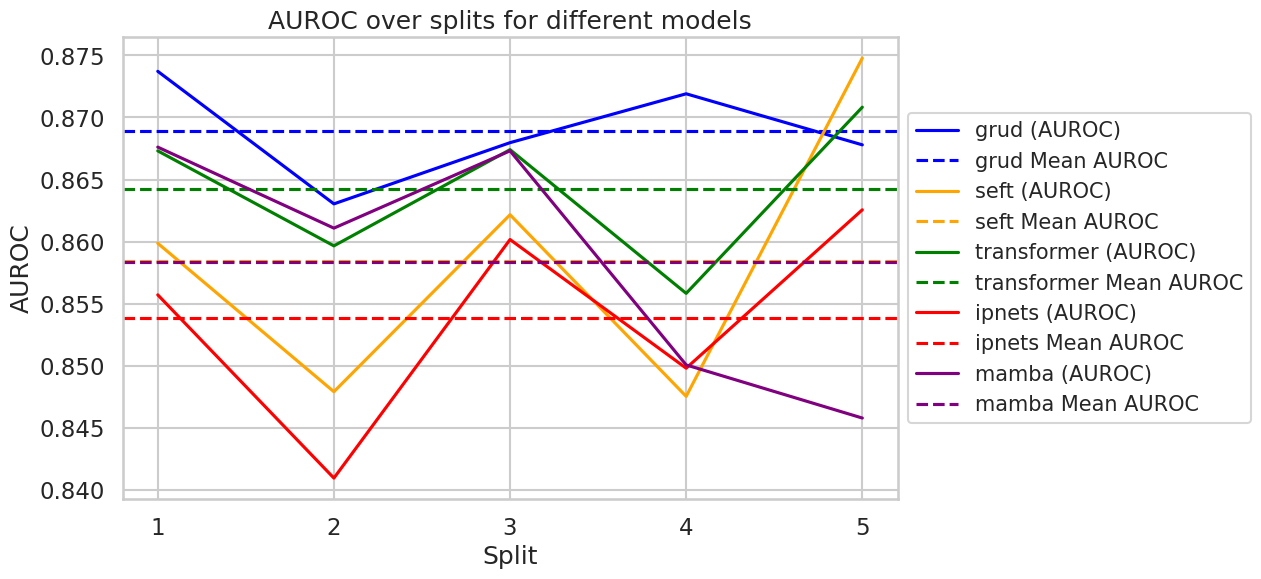

In [54]:
base_path = "latest_results"

colors = ["blue", "orange", "green", "red", "purple"]

models = {
    "grud": "grud_final_output",
    "seft": "seft_final_final_results",
    "transformer": "transformer_final_output",
    "ipnets": "ipnets_final_output",
    "mamba": "mamba_transClassifier_final_output"
}

plt.figure(figsize=(10, 6))

for i, (model_name, model_folder) in enumerate(models.items()):
    auroc_values = []
    splits = []

    for split in range(1, 6):
        split_path = os.path.join(base_path, model_folder, f"split_{split}", "test_results.json")
        with open(split_path, "r") as f:
            data = json.load(f)
            auroc_values.append(data["AUROC"])
            splits.append(split)

    summary_path = os.path.join(base_path, model_folder, "summary.json")
    with open(summary_path, "r") as f:
        summary_data = json.load(f)
        mean_auroc = summary_data["mean_auroc"]

    if mean_auroc < 0.8:
        mean_auroc = sum(auroc_values)/len(auroc_values)

    # AUROC-values for each split
    plt.plot(splits, auroc_values, label=f"{model_name} (AUROC)", color=colors[i])

    # horizontal line for mean AUROC
    plt.axhline(y=mean_auroc, color=colors[i], linestyle="--", label=f"{model_name} Mean AUROC")

plt.xlabel("Split")
plt.ylabel("AUROC")
plt.title("AUROC over splits for different models")
plt.xticks(range(1, 6))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize="small")
plt.grid(True)
plt.show()

#### Option 2: Run Mamba and baseline models with a limited amount of data

It is necessary to have access to gpu resources, in order to run EHR-Mamba

In [ ]:
# Mamba execution

!python cli.py --output_path=summary_outputs/limited_data/mamba --model_type=mamba --base_path=./P12data/subset/ --number_of_splits=1 --search_preprocessed=False

In [ ]:
# Transformer execution
!python cli.py --output_path=summary_outputs/limited_data/transformer --epochs=100 --batch_size=16 --model_type=transformer --dropout=0.2 --attn_dropout=0.1 --layers=3 --heads=1 --pooling=max --lr=0.0001 --base_path=./P12data/subset/ --number_of_splits=1

In [ ]:
# Seft execution

!python cli.py --output_path=summary_outputs/limited_data/seft --model_type=seft --epochs=100 --batch_size=128 --dropout=0.4 --attn_dropout=0.3 --heads=2 --lr=0.01 --seft_dot_prod_dim=512 --seft_n_phi_layers=1 --seft_n_psi_layers=5 --seft_n_rho_layers=2 --seft_phi_dropout=0.3 --seft_phi_width=512 --seft_psi_width=32 --seft_psi_latent_width=128 --seft_latent_width=64 --seft_rho_dropout=0.0 --seft_rho_width=256 --seft_max_timescales=1000 --seft_n_positional_dims=16 --base_path=./P12data/subset/ --number_of_splits=1

In [ ]:
# Grud execution

!python cli.py --output_path=summary_outputs/limited_data/grud --model_type=grud --epochs=100 --batch_size=32 --lr=0.0001 --recurrent_dropout=0.2 --recurrent_n_units=128 --base_path=./P12data/subset/ --number_of_splits=1

In [ ]:
#Ipnets execution

!python cli.py --output_path=summary_outputs/limited_data/ipnets --model_type=ipnets --epochs=100 --batch_size=32 --lr=0.001 --ipnets_imputation_stepsize=1 --ipnets_reconst_fraction=0.75 --recurrent_dropout=0.3 --recurrent_n_units=32 --base_path=./P12data/subset/ --number_of_splits=1

#### Option 3: Run Mamba and baseline models with all data (more time-consuming)

It is necessary to have access to gpu resources, in order to run EHR-Mamba

In [ ]:
# Mamba execution

!python cli.py --output_path=summary_outputs/all_data/mamba --model_type=mamba --base_path=./P12data/ --search_preprocessed=False

In [ ]:
# Transformer execution
!python cli.py --output_path=summary_outputs/_all_data/transformer --epochs=100 --batch_size=16 --model_type=transformer --dropout=0.2 --attn_dropout=0.1 --layers=3 --heads=1 --pooling=max --lr=0.0001 --base_path=./P12data/

In [ ]:
# Seft execution

!python cli.py --output_path=summary_outputs/all_data/seft --model_type=seft --epochs=100 --batch_size=128 --dropout=0.4 --attn_dropout=0.3 --heads=2 --lr=0.01 --seft_dot_prod_dim=512 --seft_n_phi_layers=1 --seft_n_psi_layers=5 --seft_n_rho_layers=2 --seft_phi_dropout=0.3 --seft_phi_width=512 --seft_psi_width=32 --seft_psi_latent_width=128 --seft_latent_width=64 --seft_rho_dropout=0.0 --seft_rho_width=256 --seft_max_timescales=1000 --seft_n_positional_dims=16 --base_path=./P12data/

In [ ]:
# Grud execution

!python cli.py --output_path=summary_outputs/all_data/grud --model_type=grud --epochs=100 --batch_size=32 --lr=0.0001 --recurrent_dropout=0.2 --recurrent_n_units=128 --base_path=./P12data/

In [ ]:
#Ipnets execution

!python cli.py --output_path=summary_outputs/all_data/ipnets --model_type=ipnets --epochs=100 --batch_size=32 --lr=0.001 --ipnets_imputation_stepsize=1 --ipnets_reconst_fraction=0.75 --recurrent_dropout=0.3 --recurrent_n_units=32 --base_path=./P12data/